In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import xavierUtils as xu
from matplotlib.ticker import MaxNLocator
from matplotlib import lines
import matplotlib.colors as colors 
from matplotlib.patches import Patch
%autosave 1000000

Autosaving every 1000000 seconds


### Funções 

In [4]:
import datetime as dt

def saveFigWdate(name):
    part = name.split('.')
    t = dt.datetime.now().strftime('%Y-%m-%d')
    filename = part[0]+'_'+t+'.'+part[1]
    pl.savefig(filename, bbox_inches='tight')

### Carrega dados

In [6]:
# Dados de votações:
initial_date = '2019-02-01'
final_date   = '2019-05-10'
query = 'SELECT * FROM `gabinete-compartilhado.paineis.camara_orientacao_deputado` \
WHERE data_displaced BETWEEN DATE \'{}\' AND DATE \'{}\''.format(initial_date, final_date)

r = pd.read_gbq(query, project_id='gabinete-compartilhado', 
                dialect='standard',
                private_key='../keys-configs/gabinete-compartilhado.json')

In [ ]:
#togo = r.reset_index()
#togo.to_json('../dados/votacoes/votacao+orientacao_2019-04-17.json', force_ascii=False)

In [ ]:
#r = pd.read_csv('../dados/votacoes/votacao+orientacao_2019-04-16_v2.csv',sep=';')
#r = pd.read_json('../dados/votacoes/votacao+orientacao_2019-04-17.json')

In [7]:
def countDuplicates(df):
    ndup = len(df.loc[df.duplicated()])
    return len(df), ndup, float()/len(df)

In [8]:
xu.unique(r.columns)

19: aday | ano | apoio | cod_sessao | data_displaced | deputado | diff | legislatura | nome_deputado | numero | obj_votacao | orientacao | orientacao_bool | partido_deputado | partido_orientacao | resumo | sigla_tipo | timestamp | voto


In [9]:
# Preenche partidos faltantes com 'sem partido':
# Reseta indice:
# Remove votações duplicadas:
v = r.reset_index(drop=True)
v = v.drop_duplicates()


v['partido_deputado'] = v[['partido_deputado']].fillna('S.PART.')['partido_deputado']
print len(r), len(v), float(len(v))/len(r)
print countDuplicates(v)

1946197 1946197 1.0
(1946197, 0, 0.0)


In [10]:
xu.unique(v.columns)

19: aday | ano | apoio | cod_sessao | data_displaced | deputado | diff | legislatura | nome_deputado | numero | obj_votacao | orientacao | orientacao_bool | partido_deputado | partido_orientacao | resumo | sigla_tipo | timestamp | voto


### Exploração

In [11]:
r.loc[(r.partido_deputado.isnull())&(r.legislatura==56)][['deputado','nome_deputado']].drop_duplicates()

,deputado,nome_deputado


In [12]:
xu.checkMissing(r)

Colunas com valores faltantes:
Empty DataFrame
Columns: [coluna, N, %]
Index: []


In [13]:
r.loc[r.partido_deputado=='S.Part.'][['legislatura','nome_deputado','partido_deputado']].drop_duplicates()

,legislatura,nome_deputado,partido_deputado
9490,53,Damião Feliciano,S.Part.
10784,53,Juvenil Alves,S.Part.
15587,52,Serafim Venzon,S.Part.
10227,53,Djalma Berger,S.Part.
10620,56,Luiz Antônio Corrêa,S.Part.
9722,52,Júlio Redecker,S.Part.


In [14]:
xu.mapUnique(v)


timestamp: 248 unique values.
(sample) 1999-03-10T19:23:00.000000000,  1999-03-18T16:29:00.000000000,  2003-02-26T19:14:00.000000000,  2007-02-12T16:31:00.000000000,  2007-03-15T12:53:00.000000000,  2007-05-08T17:50:00.000000000,  2007-05-09T14:37:00.000000000,  2011-02-16T22:38:00.000000000,  2011-04-05T19:11:00.000000000,  2011-04-27T18:41:00.000000000,  2015-03-05T18:41:00.000000000,  2015-03-12T18:54:00.000000000,  2015-03-24T21:02:00.000000000,  2015-04-09T16:33:00.000000000,  2015-04-09T18:01:00.000000000,  2015-05-06T21:31:00.000000000,  2015-05-07T17:28:00.000000000,  2019-02-12T16:11:00.000000000,  2019-02-14T10:33:00.000000000,  2019-02-19T18:15:00.000000000

sigla_tipo: 10 unique values.
MPV,  MSC,  PDC,  PDL,  PEC,  PL,  PLP,  PRC,  REC,  REQ

numero: 104 unique values.
(sample) 11,  37,  48,  335,  336,  341,  344,  345,  346,  351,  354,  379,  457,  637,  661,  829,  846,  1125,  4125,  7569

ano: 24 unique values.
(sample) 1996,  1997,  1998,  1999,  2000,  2001,  2002

### Análise por partidos

In [15]:
# Numa dada legislatura, fração de votos de um partido que concordam com orientação mandante:
def freqApoio(legisl,mandante,partido=None):
    if partido==None:
        s = v.loc[(v.partido_orientacao==mandante) & (v.legislatura==legisl)]['apoio']
    else:
        s = v.loc[(v.partido_orientacao==mandante) & (v.partido_deputado==partido) & (v.legislatura==legisl)]['apoio']
    if len(s)==0:
        return float('NaN') 
    return xu.freq(s, 1)    

# Determina se partido apoiou governo (% de votos > limiar) em todos os governos anteriores (com exceção da Dilma 2):
# Partidos que só aparecem no governo atual são marcados com 0
def fisiologicoQ(partido, limiar):
    leg = [51,52,53,54,56]
    f   = np.array([freqApoio(l,'Governo',partido) for l in leg])
    fPresente = f[np.isnan(f)==False]
    if len(fPresente)==1:
        return 0
    if len(fPresente)>1 and np.all(fPresente>limiar):
        return 1
    else:
        return -1

In [16]:
partidosAtuais = v.loc[(v.legislatura==56)&(v.partido_deputado.isnull()==False)].partido_deputado.unique()

In [17]:
apoioGoverno   = np.array([freqApoio(56,'Governo',p) for p in partidosAtuais])

In [18]:
fisiologico    = np.array([fisiologicoQ(p,0.8) for p in partidosAtuais])

In [19]:
apoioAcredito  = xu.freq(v.loc[(v.partido_orientacao=='Governo') & 
                               (v.nome_deputado.isin(['Tabata Amaral','Felipe Rigoni']))]['apoio'],1)
apoioByPartido = pd.DataFrame({'partido':np.append(partidosAtuais,'Acredito'), 
                               'freq':np.append(apoioGoverno,apoioAcredito), 
                               'fisio':np.append(fisiologico,False)}).sort_values('freq').reset_index()

In [33]:
# Tamanho atual da bancada:
#NdepByPartido = v.loc[v.legislatura==56].groupby('partido_deputado')['deputado'].nunique()
NdepByPartido = v.loc[v.legislatura==56].sort_values('timestamp')\
[['deputado', 'partido_deputado']].drop_duplicates(subset='deputado', keep='last').groupby('partido_deputado').size()
NdepByPartido = NdepByPartido.append(pd.Series([2],index=['Acredito']))
NdepByPartido.name = 'ndeputados'

In [34]:
# Número médio de votos em favor do governo, por partido:
apoioEvotosByPartido = apoioByPartido.join(NdepByPartido,on='partido',how='outer')
apoioEvotosByPartido['nvotosmedio'] = apoioEvotosByPartido.freq*apoioEvotosByPartido.ndeputados
#apoioEvotosByPartido = apoioEvotosByPartido.sort_values('nvotosmedio').reset_index(drop=True)

In [35]:
# debug
xu.unique(v.columns)

19: aday | ano | apoio | cod_sessao | data_displaced | deputado | diff | legislatura | nome_deputado | numero | obj_votacao | orientacao | orientacao_bool | partido_deputado | partido_orientacao | resumo | sigla_tipo | timestamp | voto


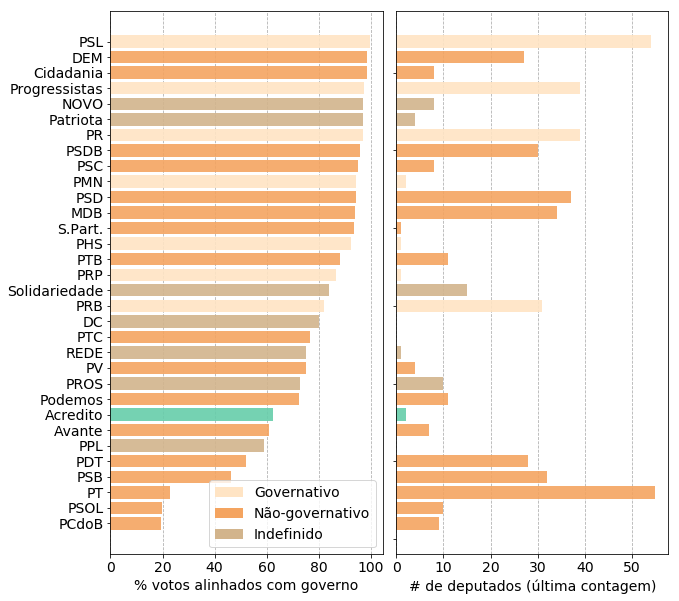

In [310]:
# Plot de todos os partidos:
def fisioC(f):
    if f==1:
        return 'bisque'
    elif f==0:
        return 'tan'
    else:
        return 'sandybrown'
cores = map(fisioC,apoioEvotosByPartido.fisio.values)
cores[apoioEvotosByPartido.loc[apoioEvotosByPartido.partido=='Acredito'].index.values[0]] = 'mediumaquamarine'
x = np.arange(1,1+len(partidosAtuais)+1)
pl.figure(figsize=(10,10))

pl.subplot(1,2,1)
pl.barh(x,100*apoioEvotosByPartido.freq.values,color=cores, zorder=2, alpha=0.9)
pl.yticks(x,apoioEvotosByPartido.partido.values)
pl.xlabel(u'% votos alinhados com governo', fontsize=14)
pl.gca().tick_params(labelsize=14)
pl.grid(axis='x',zorder=0, linestyle='--')

# Legenda:
legend_elements = [Patch(facecolor='bisque', label='Governativo'),
                   Patch(facecolor='sandybrown',     label=u'Não-governativo'),
                   Patch(facecolor='tan',     label=u'Indefinido')]
pl.legend(handles=legend_elements, fontsize=14, loc='lower right')

pl.subplot(1,2,2)
pl.barh(x,apoioEvotosByPartido.ndeputados.values,color=cores, zorder=2, alpha=0.9)
#pl.yticks(x,apoioEvotosByPartido.partido.values)
pl.gca().tick_params(labelleft=False)
pl.xlabel(u'# de deputados (última contagem)', fontsize=14)
pl.gca().tick_params(labelsize=14)
pl.grid(axis='x',zorder=0, linestyle='--')

pl.subplots_adjust(wspace=0.05)
#xu.saveFigWdate('graficos/apoio_ao_governo_partidos+tamanho.pdf')
pl.show()

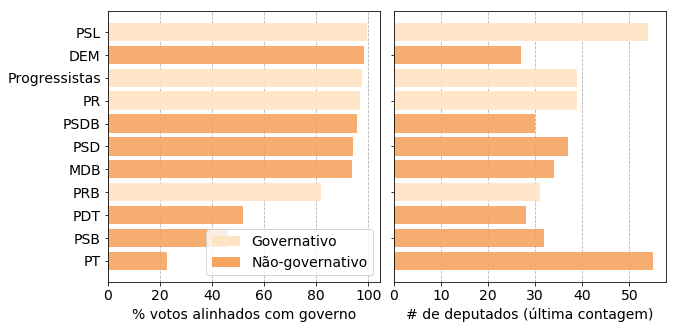

In [311]:
# Plot dos partidos com 20 ou mais deputados:
apoioEvotosByPartidoG = apoioEvotosByPartido.loc[apoioEvotosByPartido.ndeputados>=20]
partidosAtuaisG = apoioEvotosByPartidoG.partido.unique()

def fisioC(f):
    if f==1:
        return 'bisque'
    elif f==0:
        return 'tan'
    else:
        return 'sandybrown'
cores = map(fisioC,apoioEvotosByPartidoG.fisio.values)
#cores[apoioEvotosByPartidoG.loc[apoioEvotosByPartidoG.partido=='Acredito'].index.values[0]] = 'mediumaquamarine'
x = np.arange(1,1+len(partidosAtuaisG))
pl.figure(figsize=(10,5))

pl.subplot(1,2,1)
pl.barh(x,100*apoioEvotosByPartidoG.freq.values,color=cores, zorder=2, alpha=0.9)
pl.yticks(x,apoioEvotosByPartidoG.partido.values)
pl.xlabel(u'% votos alinhados com governo', fontsize=14)
pl.gca().tick_params(labelsize=14)
pl.grid(axis='x',zorder=0, linestyle='--')

# Legenda:
legend_elements = [Patch(facecolor='bisque', label='Governativo'),
                   Patch(facecolor='sandybrown',     label=u'Não-governativo')]
pl.legend(handles=legend_elements, fontsize=14, loc='lower right')

pl.subplot(1,2,2)
pl.barh(x,apoioEvotosByPartidoG.ndeputados.values,color=cores, zorder=2, alpha=0.9)
#pl.yticks(x,apoioEvotosByPartidoG.partido.values)
pl.gca().tick_params(labelleft=False)
pl.xlabel(u'# de deputados (última contagem)', fontsize=14)
pl.gca().tick_params(labelsize=14)
pl.grid(axis='x',zorder=0, linestyle='--')

pl.subplots_adjust(wspace=0.05)
#xu.saveFigWdate('graficos/apoio_ao_governo_partidosG+tamanho.pdf')
pl.show()

### Análise por deputado

In [257]:
# Verifica id. de deputados com mais de um nome:
orientGovAtual = v.loc[(v.partido_orientacao=='Governo') & (v.legislatura==56)]
grbyDep = orientGovAtual.groupby('deputado')
grbyDep['nome_deputado'].unique()[grbyDep['nome_deputado'].nunique()!=1]

deputado
204416    [Ubiratan Sanderson, Sanderson]
Name: nome_deputado, dtype: object

In [135]:
idTabata = v.loc[v.nome_deputado=='Tabata Amaral']['deputado'].unique()[0]
idFelipe = v.loc[v.nome_deputado=='Felipe Rigoni']['deputado'].unique()[0]
apoioTabata = grbyDep.get_group(idTabata)['apoio'].mean()*100
apoioFelipe = grbyDep.get_group(idFelipe)['apoio'].mean()*100

In [137]:
def depDistPlot(leg):
    orientGovAtual = v.loc[(v.partido_orientacao=='Governo') & (v.legislatura==leg)]
    grbyDep = orientGovAtual.groupby('deputado')
    apoioMedio = grbyDep['apoio'].mean().values*100
    pl.hist(apoioMedio,bins=20)
    pl.ylim([0,350])
    return np.median(apoioMedio)

513
515
523
526
527
486


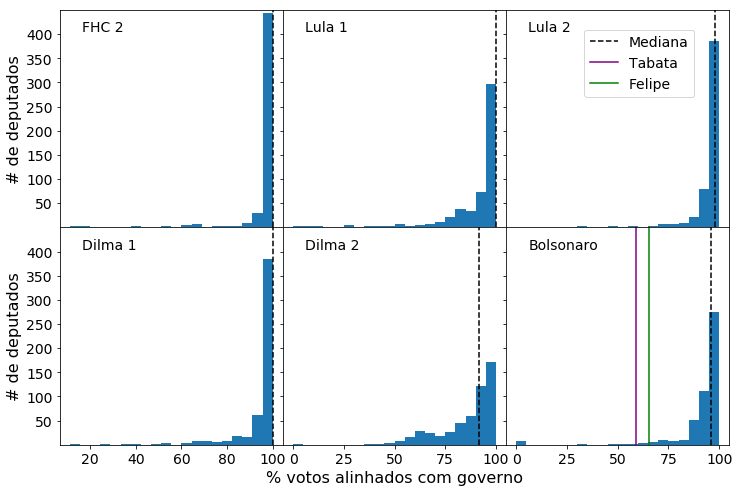

In [166]:
legList = sorted(v.legislatura.unique())
LegName = ['FHC 2','Lula 1','Lula 2','Dilma 1','Dilma 2','Bolsonaro']
pl.figure(figsize=(12,8))
nRows = 2
nCols = 3

for i in range(len(legList)):
    pl.subplot(nRows,nCols,i+1)
    # Texto:
    pl.text(0.1,0.9,LegName[i],transform = pl.gca().transAxes, fontsize=14)
    # Formatação do eixo x:
    if i < nCols*(nRows-1):
        pl.gca().tick_params(labelbottom=False)
    else:
        if (i==4): 
            pl.xlabel(u'% votos alinhados com governo', fontsize=16)
    # Formatação do eixo y:
    if i%nCols!=0:
        pl.gca().tick_params(labelleft=False)
    else:
        pl.ylabel('# de deputados', fontsize=16)
    # Plot:    
    median = depDistPlot(legList[i])
    pl.axvline(median,linestyle='--',color='k')
    # Coloca acredito:
    if legList[i]==56:
        pl.axvline(apoioTabata, color='purple')
        pl.axvline(apoioFelipe, color='g')
    pl.gca().tick_params(labelsize=14)
    pl.gca().yaxis.set_major_locator(MaxNLocator(prune='both'))
    # Coloca legenda:
    if (i==2):
        import matplotlib.colors as colors 
        vertical_lines = [lines.Line2D([], [], color='k', linestyle='--', label='Mediana'),
                          lines.Line2D([], [], color=colors.to_rgba('purple', alpha=None), linestyle='-', label='Tabata'),
                          lines.Line2D([], [], color='g', linestyle='-', label='Felipe')]
        pl.legend(handles=vertical_lines, fontsize=14, loc=(0.35,0.6))
    
pl.subplots_adjust(hspace=0,wspace=0)
#saveFigWdate('graficos/apoio_ao_governo_deputados.pdf')
#pl.show()

In [181]:
# Cria tabela de alinhamento dos deputados:

tab_alinhamento_governo = orientGovAtual.sort_values('timestamp')[['deputado', 'nome_deputado', 'partido_deputado']]\
.drop_duplicates(subset='deputado', keep='last').set_index('deputado', drop=True)\
.join(grbyDep.apoio.mean(), how='outer').sort_values(['partido_deputado', 'nome_deputado'])

tab_alinhamento_governo['apoio'] = np.round(tab_alinhamento_governo.apoio*100,1)

tab_alinhamento_governo.rename(axis='columns', inplace=True,
                               mapper={'nome_deputado':'Nome', 'partido_deputado':'Partido', 'apoio':'Alinhamento'})

tab_alinhamento_governo.to_latex('../relatorios/tab-alinhamento-governo-deputados.tex',
                                 index=False, encoding='utf8', longtable=True, decimal=',')

### Análise por votação

In [139]:
xu.unique(v.sigla_tipo)

10: MPV | MSC | PDC | PDL | PEC | PL | PLP | PRC | REC | REQ


In [140]:
# Conferindo que timestamp corresponde a uma única votação:
votosFavGovByDate = \
v.loc[v.partido_orientacao=='Governo'].sort_values('timestamp').groupby(['timestamp','resumo'])['apoio'].sum()

In [141]:
def lenEqSum(v):
    if len(v)==np.sum(v):
        return True
    else:
        return False

In [142]:
#v.loc[v.partido_orientacao=='Governo'].sort_values('timestamp').groupby(['timestamp','resumo'])\
#['apoio'].sum().sort_values(ascending=False)

In [143]:
t = v.loc[v.partido_orientacao=='Governo'].sort_values('timestamp').groupby(['timestamp','resumo'])\
['obj_votacao'].nunique()
lenEqSum(t)

True

In [144]:
v.timestamp.max()

Timestamp('2019-04-24 17:34:00')

In [145]:
anoVotacao    = np.array([x[0].year for x in votosFavGovByDate.index.values])
votosIdx      = np.arange(len(anoVotacao))
votoByVotacao = pd.DataFrame({'ano':anoVotacao, 'nvotos':np.array(votosFavGovByDate)})
grByAno       = votoByVotacao.groupby('ano')
nVotosMedio   = grByAno.mean().values

In [146]:
votosFavGovByDate['1999-02-24 17:53:00']

resumo
    408
Name: apoio, dtype: int64

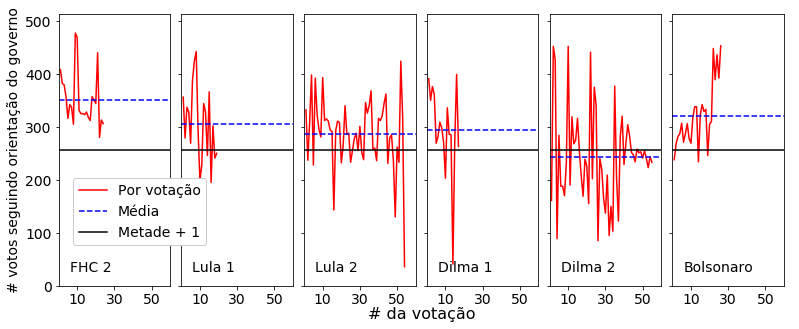

In [299]:
fig = pl.figure(figsize=(13,5))
anoUnique = votoByVotacao.ano.unique()
for i in range(len(anoUnique)):
    pl.subplot(1,len(anoUnique),i+1)
    # Text:
    pl.text(0.1,0.05, LegName[i], transform = pl.gca().transAxes, fontsize=14)
    # Plot:
    y = grByAno.get_group(anoUnique[i]).values
    x = np.arange(1,1+len(y))
    pl.plot(x,y,'r-')
    pl.axhline(513/2+1, color='k')
    pl.axhline(nVotosMedio[i], color='blue', linestyle='--')
    # Format y:
    pl.ylim([0,513])
    if i>0:
        pl.gca().tick_params(labelleft=False)
    else:
        pl.ylabel(u'# votos seguindo orientação do governo', fontsize=14)
    pl.gca().tick_params(labelsize=14)
    pl.xticks([10,30,50])
    pl.xlim([0,60])
    
    # Label x comum:
    axComum = fig.add_subplot(111, frameon=False)
    pl.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    axComum.set_xlabel(u'# da votação', fontsize=16)
    
    # Legenda:
    vertical_lines = [lines.Line2D([], [], color='red', linestyle='-', label=u'Por votação'),
                      lines.Line2D([], [], color='blue', linestyle='--', label=u'Média'),
                      lines.Line2D([], [], color='k', linestyle='-', label='Metade + 1')]
    pl.legend(handles=vertical_lines, fontsize=14, loc=(0.02,0.15), framealpha=1)
    
pl.subplots_adjust(wspace=0.1)
#xu.saveFigWdate('graficos/apoio_ao_governo_por_votacao.pdf')
pl.show()

In [314]:
xu.unique(v.columns)

19: aday | ano | apoio | cod_sessao | data_displaced | deputado | diff | legislatura | nome_deputado | numero | obj_votacao | orientacao | orientacao_bool | partido_deputado | partido_orientacao | resumo | sigla_tipo | timestamp | voto


In [316]:
# Quantas vezes o governo orientou o voto na atual legislatura:
len(v.loc[(v.partido_orientacao=='Governo')&(v.legislatura==56)][['timestamp','obj_votacao']].drop_duplicates())

25

In [317]:
len(v.loc[(v.legislatura==56)][['timestamp','obj_votacao']].drop_duplicates())

44

### Coesão partidária 

In [148]:
# Calcula tamanho médio na bancada no período:

depByLegPartido = v.loc[v.partido_deputado.isin(partidosAtuais)]\
[['legislatura','partido_deputado','deputado']].drop_duplicates()

nLegAtual    = len(np.array(legList)[np.array(legList)==56])
nLegAnterior = len(np.array(legList)[np.array(legList)<56])
nLegSDilma2  = len(np.array(legList)[np.array(legList)<55])

pSizeAtual    = depByLegPartido.loc[(depByLegPartido.legislatura==56)].groupby('partido_deputado')['deputado'].size()/nLegAtual
pSizeAnterior = depByLegPartido.loc[(depByLegPartido.legislatura<56)].groupby('partido_deputado')['deputado'].size()/nLegAnterior
pSizeSDilma2  = depByLegPartido.loc[(depByLegPartido.legislatura<55)].groupby('partido_deputado')['deputado'].size()/nLegSDilma2

In [149]:
# Prepara bases para extrair aderência à liderança dos partidos:
baseCoesao = v.loc[(v.partido_deputado.isin(partidosAtuais))&(v.partido_orientacao.isin(partidosAtuais))&
                   (v.partido_deputado==v.partido_orientacao)]
baseCoesaoAtual    = baseCoesao.loc[baseCoesao.legislatura==56]
baseCoesaoAnterior = baseCoesao.loc[baseCoesao.legislatura<56]
baseCoesaoSDilma2  = baseCoesao.loc[baseCoesao.legislatura<55]

In [150]:
# Calcula os apoios aos partidos nos períodos:
apoioAtual    =    baseCoesaoAtual.groupby('partido_deputado')['apoio'].mean()
apoioAnterior = baseCoesaoAnterior.groupby('partido_deputado')['apoio'].mean()
apoioSDilma2  =  baseCoesaoSDilma2.groupby('partido_deputado')['apoio'].mean()

In [151]:
def idxComplement(s1, s2):
    return np.array(list(set(s1.index.values)-set(s2.index.values)))

In [152]:
# Construindo base de fidelidade e poder:
apoioAtual.name    = 'atual'
apoioAnterior.name = 'anterior'
apoioSDilma2.name  = 'sdilma2'
pSizeAnterior.name = 'Nanterior'
pSizeSDilma2.name  = 'Nsdilma2'
pSizeAtual.name    = 'Natual'

In [153]:
apoioPartidos = pd.DataFrame()
apoioPartidos = apoioPartidos.join(apoioAtual,    how='outer')
apoioPartidos = apoioPartidos.join(apoioAnterior, how='outer')
apoioPartidos = apoioPartidos.join(apoioSDilma2,  how='outer')
apoioPartidos = apoioPartidos.join(pSizeAtual,    how='outer')
apoioPartidos = apoioPartidos.join(pSizeAnterior, how='outer')
apoioPartidos = apoioPartidos.join(pSizeSDilma2,  how='outer')

In [154]:
apoioPartidos['Patual']    = apoioPartidos[['atual']].fillna(apoioPartidos['atual'].mean())['atual']*apoioPartidos['Natual']
apoioPartidos['Panterior'] = apoioPartidos[['anterior']].fillna(apoioPartidos['anterior'].mean())['anterior']*apoioPartidos['Nanterior']
apoioPartidos['Psdilma2']  = apoioPartidos[['sdilma2']].fillna(apoioPartidos['sdilma2'].mean())['sdilma2']*apoioPartidos['Nsdilma2']

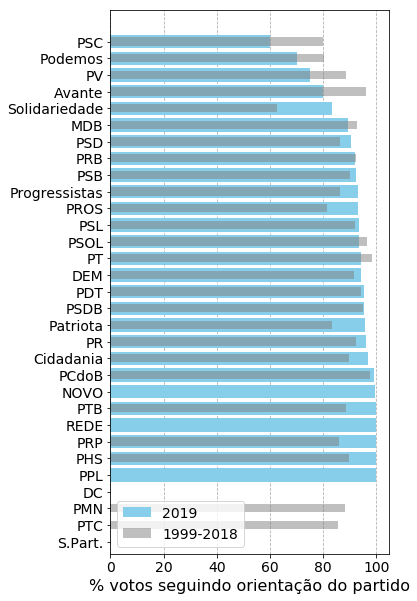

In [304]:
partidosSapoio = apoioPartidos.sort_values('atual')

pl.figure(figsize=(5,10))
x = np.arange(1,1+len(partidosSapoio))

pl.barh(x,partidosSapoio.atual[::-1]*100, color='skyblue', label='2019', zorder=2)
pl.barh(x,partidosSapoio.anterior[::-1]*100, height=0.5, color='gray', alpha=0.5, label='1999-2018', zorder=2)
#pl.bar(x,partidosSapoio.sdilma2*100, width=0.2, color='red', alpha=0.5)
pl.yticks(x,partidosSapoio.index.values[::-1])
pl.gca().tick_params(labelsize=14)
pl.xlabel(u'% votos seguindo orientação do partido', fontsize=16)
pl.legend(loc='lower left', fontsize=14)
pl.grid(axis='x', zorder=0, linestyle='--')
#saveFigWdate('graficos/fidelidade_partidaria_media.pdf')
pl.show()

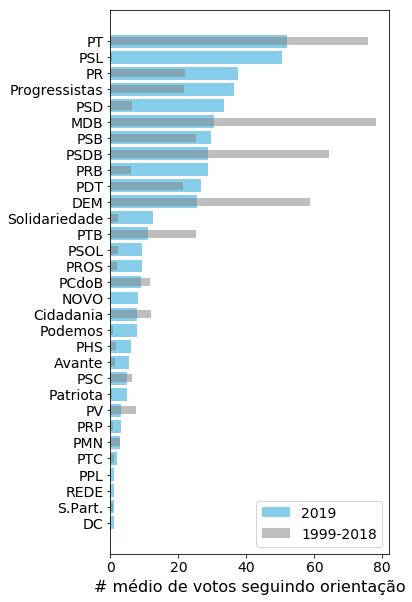

In [305]:
partidosSpoder = apoioPartidos.sort_values('Patual')

pl.figure(figsize=(5,10))
x = np.arange(1,1+len(partidosSpoder))

pl.barh(x,partidosSpoder.Patual, color='skyblue', label='2019')
pl.barh(x,partidosSpoder.Panterior, height=0.5, color='gray', alpha=0.5, label='1999-2018')
#pl.bar(x,partidosSpoder.sdilma2, width=0.2, color='red', alpha=0.5)
pl.yticks(x,partidosSpoder.index.values)

pl.gca().tick_params(labelsize=14)
#pl.grid(color='lightgray')
pl.xlabel(u'# médio de votos seguindo orientação', fontsize=16)
pl.legend(loc='lower right', fontsize=14)
#saveFigWdate('graficos/poder_partidario.pdf')
pl.show()

### Fidelidade partidária (por deputados)

In [293]:
# Cria tabela de alinhamento dos deputados ao governo:
# ATENÇÃO!! USA VARIÁVEIS QUE FORAM DEFINIDAS ACIMA E SERÃO ALTERADAS ABAIXO!

tab_alinhamento_governo = orientGovAtual.sort_values('timestamp')[['deputado', 'nome_deputado', 'partido_deputado']]\
.drop_duplicates(subset='deputado', keep='last').set_index('deputado', drop=True)\
.join(grbyDep.apoio.mean(), how='outer').sort_values(['partido_deputado', 'nome_deputado'])

tab_alinhamento_governo['apoio'] = np.round(tab_alinhamento_governo.apoio*100,1)

tab_alinhamento_governo.rename(axis='columns', inplace=True,
                               mapper={'nome_deputado':'Nome', 
                                       'partido_deputado':'Partido', 
                                       'apoio':'Al. gov.'})

In [294]:
# Exporta tabela:
#tab_alinhamento_governo.to_latex('../relatorios/tab-alinhamento-governo-deputados.tex',
#                                 index=False, encoding='utf8', longtable=True, decimal=',')

In [295]:
def depDistPlot(leg):
    orientPartido = v.loc[(v.partido_orientacao==v.partido_deputado) & (v.legislatura==leg)]
    grbyDep = orientPartido.groupby('deputado')
    apoioMedio = grbyDep['apoio'].mean().values*100
    pl.hist(apoioMedio,bins=20)
    pl.ylim([0,450])
    print len(apoioMedio)
    return np.median(apoioMedio)

In [296]:
orientPartAtual = v.loc[(v.partido_orientacao==v.partido_deputado) & (v.legislatura==56)]
grbyDepP = orientPartAtual.groupby('deputado')
fidTabata = grbyDepP.get_group(idTabata)['apoio'].mean()*100
fidFelipe = grbyDepP.get_group(idFelipe)['apoio'].mean()*100

In [297]:
# Adiciona alinhamento ao partido na tabela:
Norient_by_deputado = grbyDepP.apoio.size()
Norient_by_deputado.name = 'norient'

tab_alinhamento_final = tab_alinhamento_governo\
.join(Norient_by_deputado)\
.join(np.round(grbyDepP.apoio.mean()*100,1))\
.rename(axis='columns', mapper={'apoio':'Al. part.'})
tab_alinhamento_final['norient'].fillna(0, inplace=True)
tab_alinhamento_final['norient'] = tab_alinhamento_final['norient'].astype(int)
tab_alinhamento_final.rename(axis='columns', mapper={'norient':u'# Or. part.'}, inplace=True)

In [298]:
# Exporta tabela:
tab_alinhamento_final.to_latex('../relatorios/tab-alinhamento-deputados.tex',
                                 index=False, encoding='utf8', longtable=True, decimal=',', na_rep='-')

513
515
523
526
527
486


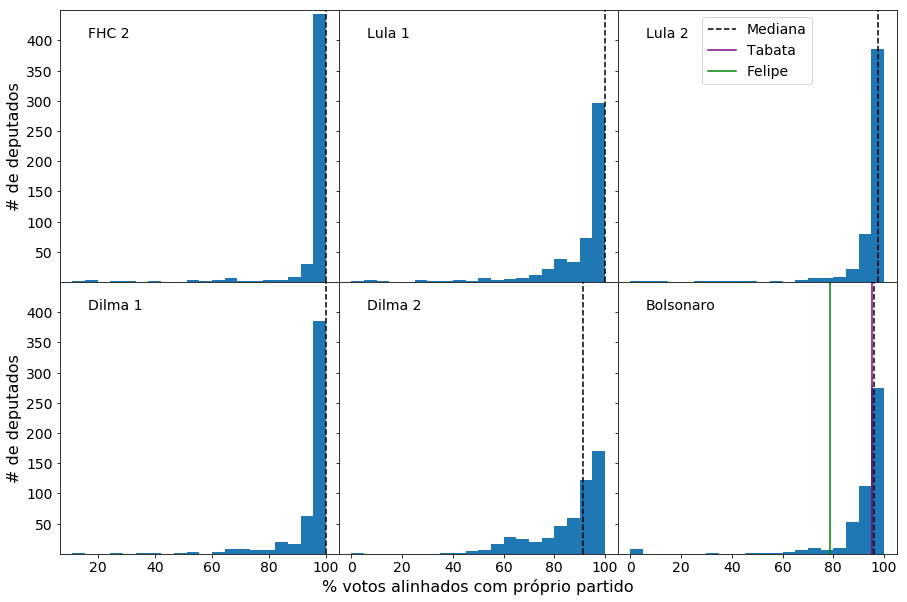

In [313]:
legList = sorted(v.legislatura.unique())
LegName = ['FHC 2','Lula 1','Lula 2','Dilma 1','Dilma 2','Bolsonaro']
pl.figure(figsize=(15,10))
nRows = 2
nCols = 3

for i in range(len(legList)):
    pl.subplot(nRows,nCols,i+1)
    # Texto:
    pl.text(0.1,0.9,LegName[i],transform = pl.gca().transAxes, fontsize=14)
    # Formatação do eixo x:
    if i < nCols*(nRows-1):
        pl.gca().tick_params(labelbottom=False)
    else:
        if (i==4):
            pl.xlabel(u'% votos alinhados com próprio partido', fontsize=16)
    # Formatação do eixo y:
    if i%nCols!=0:
        pl.gca().tick_params(labelleft=False)
    else:
        pl.ylabel('# de deputados', fontsize=16)
    # Plot:    
    median = depDistPlot(legList[i])
    pl.axvline(median,linestyle='--',color='k')
    # Coloca acredito:
    if legList[i]==56:
        pl.axvline(fidTabata, color='purple')
        pl.axvline(fidFelipe, color='g')
    pl.gca().tick_params(labelsize=14)
    pl.gca().yaxis.set_major_locator(MaxNLocator(prune='both'))
    # Coloca legenda:
    if (i==2):
        import matplotlib.colors as colors 
        vertical_lines = [lines.Line2D([], [], color='k', linestyle='--', label='Mediana'),
                          lines.Line2D([], [], color=colors.to_rgba('purple', alpha=None), linestyle='-', label='Tabata'),
                          lines.Line2D([], [], color='g', linestyle='-', label='Felipe')]
        pl.legend(handles=vertical_lines, fontsize=14, loc='upper center')

pl.subplots_adjust(hspace=0,wspace=0)
#xu.saveFigWdate('graficos/fidelidade_partidaria_deputados.pdf')
pl.show()

# Testes

In [64]:
# Deputados trocam de partido:

t = v.loc[v.legislatura==56].groupby('deputado')['partido_deputado']
print t.unique().loc[(t.nunique()>1)]

print v.loc[v.legislatura==56].deputado.nunique(), 
v.loc[v.legislatura==56].groupby('partido_deputado')['deputado'].nunique().sum()

deputado
109429              [PTC, PRB]
115746               [PHS, PR]
146788               [PHS, PP]
178863             [PPL, PROS]
204427               [PHS, PR]
204432    [PTC, Solidariedade]
204448           [DC, S.Part.]
204463              [PRP, PSD]
204510               [PHS, PP]
204517               [PMN, PR]
204550          [Patriota, PR]
204554               [PHS, PR]
204567               [PRP, PR]
Name: partido_deputado, dtype: object
517

530

# Lixo

In [24]:
# Tamanho das bancadas:
query = 'SELECT * FROM `gabinete-compartilhado.analise_congresso_poder.camara_sigla_numero_membros_tab`'
partido_size = pd.read_gbq(query, project_id='gabinete-compartilhado', 
                dialect='standard',
                private_key='../keys-configs/gabinete-compartilhado.json')

temp = pd.DataFrame()
temp['atuais'] = pd.Series(partidosAtuais, name='atuais')
partido_size.merge(temp, left_on='sigla_nova', right_on='atuais', how='outer')

,nome,sigla_nova,total_membros,atuais
0,Partido Republicano Progressista,PRP,1.0,PRP
1,Partido Humanista da Solidariedade,PHS,1.0,PHS
2,Rede Sustentabilidade,REDE,1.0,REDE
3,Partido da Mobilização Nacional,PMN,2.0,PMN
4,Partido Verde,PV,4.0,PV
5,Patriota,Patriota,4.0,Patriota
6,Avante,Avante,7.0,Avante
7,Cidadania,Cidadania,8.0,Cidadania
8,Partido Social Cristão,PSC,8.0,PSC
9,Partido Comunista do Brasil,PCdoB,8.0,PCdoB


In [ ]:
print xu.unique(v.partido_orientacao)
print xu.unique(v.legislatura)
print xu.freq(v.voto,'Obstrução'), xu.freq(v.orientacao,'Obstrução')
print xu.freq(v.voto,'Sim'), xu.freq(v.orientacao,'Sim')
print xu.freq(v.voto,'Não'), xu.freq(v.orientacao,'Não')

In [ ]:
listaLegislatura = sorted(v.legislatura.unique())
anoLegislatura   = 2019 - 4*(56-np.array(listaLegislatura))

def histApoio(mandante, partido=None):
    return np.array([freqApoio(l, mandante, partido) for l in listaLegislatura])

In [ ]:
def histBarPlot(mandante, partido=None):
    x = np.arange(1,1+len(anoLegislatura))
    y = 100*histApoio(mandante,partido)
    pl.bar(x,y)
    pl.xticks(x, anoLegislatura)
    pl.xlabel('Ano')
    pl.ylabel('% de apoio')
    if partido==None:
        pl.title(mandante+' orienta geral')
    else:
        pl.title(mandante+' orienta '+partido)
    pl.ylim([0,105])

In [ ]:
pl.figure(figsize=(6*2.5,6*2.5))
for n in range(36):
    pl.subplot(6,6,n+1)
    histBarPlot('Governo', sorted(v.partido_deputado.unique())[1+n])
pl.tight_layout()
pl.show()

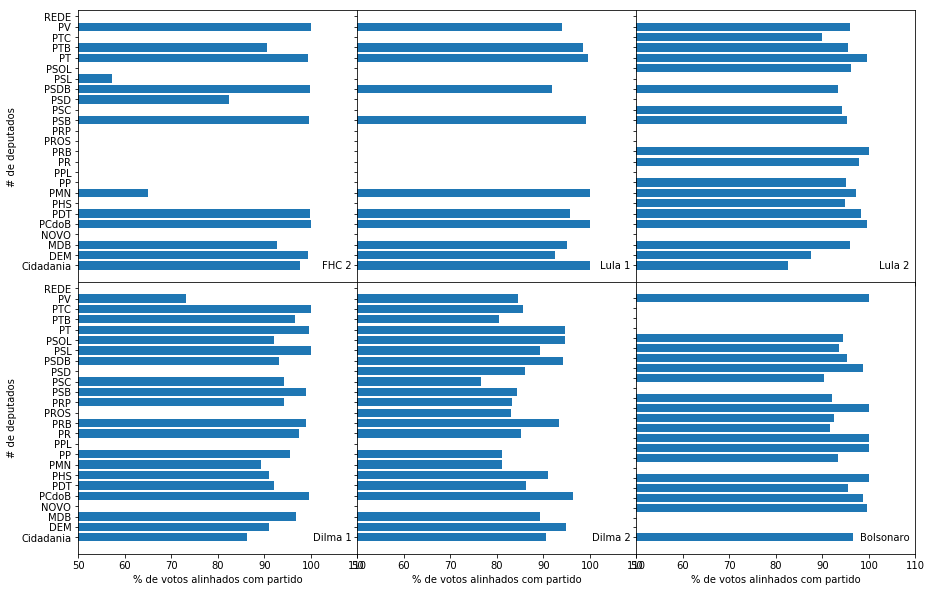

In [205]:
legList = sorted(v.legislatura.unique())
LegName = ['FHC 2','Lula 1','Lula 2','Dilma 1','Dilma 2','Bolsonaro']
pl.figure(figsize=(15,10))
nRows = 2
nCols = 3


x = np.arange(1,len(partidosAtuais))
apoioMin = int(coesaoByLegPartido.apoio.min()*10)*10

for i in range(len(legList)):
    pl.subplot(nRows,nCols,i+1)
    # Texto:
    pl.text(0.98,0.05,LegName[i],transform = pl.gca().transAxes, ha='right')
    # Formatação do eixo x:
    if i < nCols*(nRows-1):
        pl.gca().tick_params(labelbottom=False)
    else:
        pl.xlabel('% de votos alinhados com governo')
    # Formatação do eixo y:
    if i%nCols!=0:
        pl.gca().tick_params(labelleft=False)
    else:
        pl.ylabel('# de deputados')
    # Plot:
    pl.barh(x,100*pivotCoesao[legList[i]].values)
    pl.yticks(x,pivotCoesao[legList[i]].index.values)
    pl.xlabel('% de votos alinhados com partido')
    pl.xlim([apoioMin,110])
    # Coloca acredito:
    #if legList[i]==56:
    
    
pl.subplots_adjust(hspace=0,wspace=0)
pl.show()